In [1]:
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable, get_cmap
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit, root, fsolve
from scipy.special import jv

In [2]:
# Constant
c0 = 3e8

In [3]:
wwv = 12 # Waveguide Width (12 μm)

raw_data = pd.read_csv(f"./Data/rpe_mode0_disp.csv").to_numpy()
lbd_data = raw_data[:,0]; n_data = raw_data[:,1]
nsq_data = n_data ** 2

raw_data1 = pd.read_csv(f"./Data/rpe_mode1_disp.csv").to_numpy()
lbd_data1 = raw_data1[:,0]; n_data1 = raw_data1[:,1]
nsq_data1 = n_data1 ** 2

# Data for comparison
comp_data0 = pd.read_csv(f"./Data/rpe_dispersion_w12.csv", header=None).to_numpy()

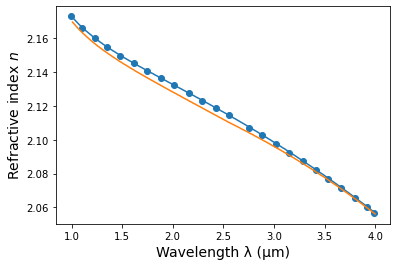

In [4]:
# Mode 0 coincides with the data Ryan plotted
plt.scatter(comp_data0[:,0], comp_data0[:,1])
plt.plot(raw_data[:,0], raw_data[:,1])
plt.plot(raw_data1[:,0], raw_data1[:,1])
plt.xlabel("Wavelength λ (μm)", fontsize = 14)
plt.ylabel("Refractive index $n$", fontsize = 14)

plt.show()

# Dispersion profile of RPE Waveguide

In [5]:
# Generic rational form
def f_index_sq(λin, Avec, Bvec):
    """
    Rational function to fit the n^2
    This is a generalization of the Sellmeier form
        n^2 - 1 = Σ(Ak * λ^(-2k))/[1 + (Bk * λ^(-2k))] 
    
    Input:
        λin: Input wavelength
        Avec, Bvec: Vector specifying {Ak} and {Bk}
    
    Return n^2
    """
    # Check dimension
    if np.ndim(λin) == 0:
        λ = np.array([λin])
    elif np.ndim(λin) > 1:
        raise RuntimeError("Check your wavelength input dimension!")
    else:
        λ = λin
    
    # Numerator
    lbd_arr = np.array([1/(λ ** (2*k)) for k in range(len(Avec))])
    newA = np.reshape(Avec, (len(Avec),-1))
    num = sum(newA * lbd_arr)
    
    # Denominator
    lbd_arr = np.array([1/(λ ** (2*k+2)) for k in range(len(Bvec))])
    newB = np.reshape(Bvec, (len(Bvec),-1))
    den = 1 + sum(newB * lbd_arr)
    out = 1 + num/den
    return out

def f_index(λin, Avec, Bvec):
    """
    Calculating index of refraction n
    """
    return np.sqrt(f_index_sq(λin, Avec, Bvec))

# The derivative
def df_index(λin, Avec, Bvec):
    """
    Calculating the derivative of the index of refraction n
    """
    # Check dimension
    if np.ndim(λin) == 0:
        λ = np.array([λin])
    elif np.ndim(λin) > 1:
        raise RuntimeError("Check your wavelength input dimension!")
    else:
        λ = λin
    
    nn = f_index(λin, Avec, Bvec)
    
    # ft, dft, gt, dgt
    newA = np.reshape(Avec, (len(Avec),-1))
    ft = sum(newA * np.array([1/(λ ** (2*k)) for k in range(len(Avec))]))
    dft = -2 * sum(newA[1:] * np.array([k/(λ ** (2*k+1)) for k in range(1,len(Avec))]))
    
    newB = np.reshape(Bvec, (len(Bvec),-1))
    gt = 1 + sum(newB * np.array([1/(λ ** (2*k+2)) for k in range(len(Bvec))]))
    dgt = -2 * sum(newB * np.array([(k+1)/(λ ** (2*k+3)) for k in range(len(Bvec))]))
    
    # Numerator
    num = gt * dft - ft * dgt
    
    # Denominator
    den = 2 * nn * (gt ** 2)
    out = num/den
    return out

# Group index
def f_gr_index(λin, Avec, Bvec):
    """
    Calculating group index
    n_g = n - λ * (dn/dλ)
    """
    out = f_index(λin, Avec, Bvec) - λin * df_index(λin, Avec, Bvec)
    return out

In [6]:
# Some speific cases
def f_index_sq_22(λ, a1, a2, b1, b2):
    Avec = np.array([a1, a2])
    Bvec = np.array([b1, b2])
    return f_index_sq(λ, Avec, Bvec)

def f_index_sq_32(λ, a1, a2, a3, b1, b2):
    Avec = np.array([a1, a2, a3])
    Bvec = np.array([b1, b2])
    return f_index_sq(λ, Avec, Bvec)

def f_index_sq_33(λ, a1, a2, a3, b1, b2, b3):
    Avec = np.array([a1, a2, a3])
    Bvec = np.array([b1, b2, b3])
    return f_index_sq(λ, Avec, Bvec)

def f_index_sq_42(λ, a1, a2, a3, a4, b1, b2):
    Avec = np.array([a1, a2, a3, a4])
    Bvec = np.array([b1, b2])
    return f_index_sq(λ, Avec, Bvec)

In [7]:
pars_fit_22 = curve_fit(f_index_sq_22, lbd_data, nsq_data)[0]
Avec_22 = pars_fit_22[:2]; Bvec_22 = pars_fit_22[2:]
pars_fit_33 = curve_fit(f_index_sq_33, lbd_data, nsq_data)[0]
Avec_33 = pars_fit_33[:3]; Bvec_33 = pars_fit_33[3:]
pars_fit_42 = curve_fit(f_index_sq_42, lbd_data, nsq_data)[0]
Avec_42 = pars_fit_42[:4]; Bvec_42 = pars_fit_42[4:]

In [8]:
# Try to interpolate/ extrapolate the index of refraction
lbd_vec = np.linspace(0.5,4.01,100)
n_fit_vec_22 = f_index(lbd_vec, Avec_22, Bvec_22)
n_fit_vec_33 = f_index(lbd_vec, Avec_33, Bvec_33)
n_fit_vec_42 = f_index(lbd_vec, Avec_42, Bvec_42)

In [123]:
Bvec_33

array([ 675.70073585, 6030.11506546, -190.42454661])

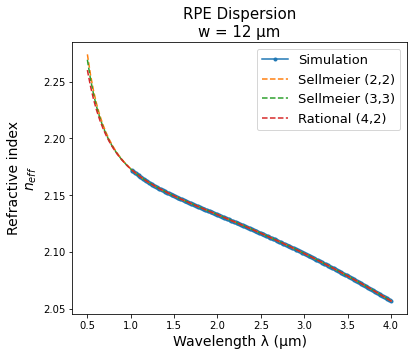

In [9]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
ax.plot(lbd_data, n_data, 'o-', markersize = 3, label = "Simulation")
ax.plot(lbd_vec, n_fit_vec_22, linestyle = "dashed", label = "Sellmeier (2,2)")
ax.plot(lbd_vec, n_fit_vec_33, linestyle = "dashed", label = "Sellmeier (3,3)")
ax.plot(lbd_vec, n_fit_vec_42, linestyle = "dashed", label = "Rational (4,2)")
ax.set_title(f"RPE Dispersion\nw = {wwv} μm", fontsize = 15)
ax.set_xlabel("Wavelength λ (μm)", fontsize = 14)
ax.set_ylabel("Refractive index\n$n_{eff}$", fontsize = 14)
ax.legend(fontsize = 13)

plt.savefig("./Figures/fig_neff_w12.png", bbox_inches="tight")
plt.show()

In [10]:
# Extraordinary refractive index
def n_index_e(λ, T):
    f = (T - 24.5) * (T + 570.82)
    n_sq = 5.35583 + 4.629e-7 * f - 1.5334e-2 * λ**2
    dn1 = (0.100473 + 3.862e-8 * f)/(λ**2 - (0.20692 - 0.89e-8 * f)**2)
    dn2 = (100 + 2.657e-5 * f)/(λ**2 - 11.34927**2)
    n_sq += (dn1 + dn2)
    return np.sqrt(n_sq)

In [11]:
lbd_vec = np.linspace(0.5,4.01,100)
ne_vec = n_index_e(lbd_vec, 50.0)

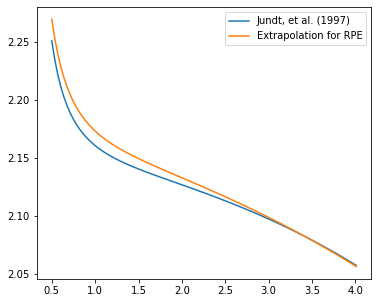

In [12]:
# Comparing with Jundt, et al. (1997)
fig, ax = plt.subplots(1,1,figsize = (6,5))
ax.plot(lbd_vec, ne_vec, label = "Jundt, et al. (1997)")
ax.plot(lbd_vec, n_fit_vec_33, label = "Extrapolation for RPE")

ax.legend(loc = "upper right")
plt.show()

In [13]:
lbd_vec = np.linspace(0.8,4.2,100)
dn_fit_vec_22 = df_index(lbd_vec, Avec_22, Bvec_22)
dn_fit_vec_33 = df_index(lbd_vec, Avec_33, Bvec_33)
dn_fit_vec_42 = df_index(lbd_vec, Avec_42, Bvec_42)

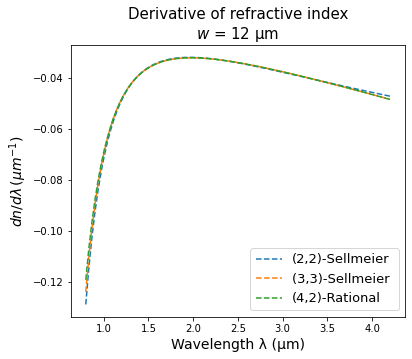

In [14]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
ax.plot(lbd_vec, dn_fit_vec_22, linestyle = "dashed", label = "(2,2)-Sellmeier")
ax.plot(lbd_vec, dn_fit_vec_33, linestyle = "dashed", label = "(3,3)-Sellmeier ")
ax.plot(lbd_vec, dn_fit_vec_42, linestyle = "dashed", label = "(4,2)-Rational")
ax.set_title(f"Derivative of refractive index\n$w$ = {wwv} μm", fontsize = 15)
ax.set_xlabel("Wavelength λ (μm)", fontsize = 14)
ax.set_ylabel("$dn/d\lambda\,(μm^{-1})$", fontsize = 14)
ax.legend(fontsize = 13)

plt.savefig("./Figures/fig_dndl_w12.png", bbox_inches="tight")
plt.show()

In [15]:
lbd_vec = np.linspace(0.99,4.01,100)
n_gr_fit_vec_22 = f_gr_index(lbd_vec, Avec_22, Bvec_22)
n_gr_fit_vec_33 = f_gr_index(lbd_vec, Avec_33, Bvec_33)
n_gr_fit_vec_42 = f_gr_index(lbd_vec, Avec_42, Bvec_42)

In [16]:
# Compare with the data from Mayer, et al., 2016
check_sig = pd.read_csv("./Data/chris_rpe_signal_disp_w12.csv").to_numpy()
check_idl = pd.read_csv("./Data/chris_rpe_idler_disp_w12.csv").to_numpy()

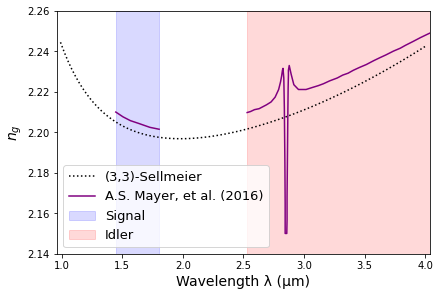

In [17]:
fig, ax = plt.subplots(1,1,figsize = (6,4), constrained_layout=True)
# ax.plot(lbd_vec, n_gr_fit_vec_22, linestyle = "dotted", label = "Fit (2,2)")
ax.plot(lbd_vec, n_gr_fit_vec_33, color = "black", linestyle = "dotted", label = "(3,3)-Sellmeier")
# ax.plot(lbd_vec, n_gr_fit_vec_42, linestyle = "dotted", label = "Fit (4,2)")

ax.plot(check_sig[:,0], check_sig[:,1], color = "purple", label = "A.S. Mayer, et al. (2016)")
ax.plot(check_idl[:,0], check_idl[:,1], color = "purple")
ax.axvspan(np.min(check_sig[:,0]), np.max(check_sig[:,0]), color = "blue", label = "Signal", alpha = 0.15)
ax.axvspan(np.min(check_idl[:,0]), np.max(check_idl[:,0]), color = "red",  label = "Idler", alpha = 0.15)

# ax.set_title(f"Group refractive index\nw = {wwv} μm", fontsize = 15)
ax.set_xlabel("Wavelength λ (μm)", fontsize = 14)
ax.set_ylabel("$n_{g}$", fontsize = 14)
ax.legend(fontsize = 13, loc = "lower left")
ax.set_xlim(0.96, 4.04)
ax.set_ylim(2.14,2.26)

plt.savefig("./Figures/fig_ngr_w12.png", bbox_inches="tight")
plt.show()

# Group velocity & quasi phase matching condition

In [83]:
def diff_ngr(λ0, λ1, Avec, Bvec):
    λ2 = λ0*λ1 / (λ1 - λ0);
    ng1 = f_gr_index(λ1, Avec, Bvec)
    ng2 = f_gr_index(λ2, Avec, Bvec)
    return ng1 - ng2

def qpm_dβ(dp, λ0, λ1, Avec, Bvec, sgn = 1):
    dk = (2 * np.pi) / dp;
    
    # Vacuum wavelength
    λ2 = λ0*λ1 / (λ1 - λ0);
    
    n0 = f_index(λ0, Avec, Bvec)
    n1 = f_index(λ1, Avec, Bvec)
    n2 = f_index(λ2, Avec, Bvec)
    
    out = 2*np.pi *(n0/λ0 - n1/λ1 - n2/λ2) - sgn * dk
    return out

In [84]:
# Group index matching
def match_ngr(λ0, Avec, Bvec, Δ=0, f=0.15):
    λ1 = None; λ2 = None;
    res = root(lambda l1: diff_ngr(λ0, l1, Avec, Bvec) - (Δ * λ0)/(2*np.pi), λ0 * (1 + f))
    if res.success:
        λ1 = (res.x).item()
        λ2 = λ0*λ1 / (λ1 - λ0)        
    return [λ0, λ1, λ2]

def match_ngr_full(λ0list, Avec, Bvec, off=0, f=0.15, L = None):
    if L is None:
        Δ = 0
    else:
        Δ = off/L
    
    out0 = np.array([match_ngr(lbd, Avec, Bvec, f=f, Δ=Δ) for lbd in λ0list])
    id0 = np.where(out0[:,1] != None)
    out0 = out0[id0]
    return out0

In [85]:
# Matching QPM
# First phase - scan over pump
def match_qpm_1(λ0, dp, Avec, Bvec, Δ=0, f=0.3, sgn = 1):
    """
    QPM matching - changing the pump wavelength
    
    Inputs:
    λ0: Pump wavelength
    dp: The poling period
    Avec: Refractive index numerator coefficients
    Bvec: Refractive index denominator coefficients
    
    Optional
    Δ: The deviation from QPM (typically π/L)
        Default: 0 (Perfect QPM)
    f: Factor to determine the starting point for root solver
    """
    λ1 = None; λ2 = None;
    res = root(lambda l1: qpm_dβ(dp, λ0, l1, Avec, Bvec, sgn = sgn) - Δ, λ0 * (1 + f))
    if res.success:
        λ1 = (res.x).item()
        λ2 = λ0*λ1 / (λ1 - λ0)        
    return [λ0, λ1, λ2]

# Second phase - scan over signal/ idler
def match_qpm_2(λ1, dp, Avec, Bvec, Δ=0, x0=0.85, sgn = 1):
    λ0 = None; λ2 = None;
    res = root(lambda l0: qpm_dβ(dp, l0, λ1, Avec, Bvec, sgn = sgn) - Δ, x0)
    if res.success:
        λ0 = (res.x).item()
        λ2 = λ0*λ1 / (λ1 - λ0)        
    return [λ0, λ1, λ2]

# Total algorithm
def match_qpm_full(λ0list, dp, Avec, Bvec, off=0, f=0.15, dλ = 2e-3, sgn = 1, L = None):
    if L is None:
        Δ = 0
    else:
        Δ = off/L
    
    # Segment 1
    out1 = np.array([match_qpm_1(lbd, dp, Avec, Bvec, f=f, Δ=Δ, sgn = sgn) for lbd in λ0list])
    qpm_id1 = np.where(out1[:,1] != None)[0]
    out1 = out1[qpm_id1]
    
    # Mark the region to carry out the phase matching 2
    x0 = out1[0,0]
    lbd_ss = np.arange(out1[0,1], out1[0,2] + dλ/2, dλ)
    
    # Segment 2
    out2 = np.array([match_qpm_2(lbd, dp, Avec, Bvec, Δ=Δ, x0=x0, sgn = sgn) for lbd in lbd_ss])
    qpm_id2 = np.where(out2[:,0] != None)[0]
    out2 = out2[qpm_id2]
    return out1, out2

In [95]:
lbd_qpm = np.arange(0.8, 1.15 + 1e-4, 1e-3);
A_qpm = Avec_33; B_qpm = Bvec_33;
L_pole = 25.61
L_ppln = 25000

ngr_sols = match_ngr_full(lbd_qpm, A_qpm, B_qpm, f = 0.15)
qpm_sols_1, qpm_sols_2 = match_qpm_full(lbd_qpm, L_pole, Avec_42, Bvec_42)

In [96]:
λ1a = np.arange(1.3, 3.5 + 1e-4, 0.01)
test = qpm_dβ(24.2, 0.99, λ1a, Avec_33, Bvec_33) * (0.2 * L_ppln)

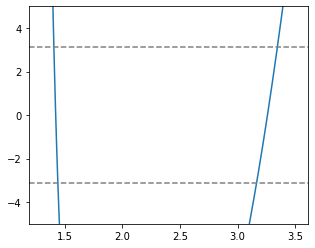

In [97]:
fig, ax = plt.subplots(1,1,figsize = (5,4))
ax.plot(λ1a, test)
ax.axhline(np.pi, linestyle="dashed", color = "gray")
ax.axhline(-np.pi, linestyle="dashed", color = "gray")
ax.set_ylim(-5,5)
plt.show()

In [98]:
ngr_sols_l1p = match_ngr_full(lbd_qpm, A_qpm , B_qpm , f = 0.15, off=np.pi, L = L_ppln)
ngr_sols_l1m = match_ngr_full(lbd_qpm, A_qpm , B_qpm, f = 0.15, off=-np.pi, L = L_ppln)

In [99]:
qpm_sols_1_p, qpm_sols_2_p = match_qpm_full(lbd_qpm, L_pole, Avec_42, Bvec_42, off = np.pi, L = L_ppln)
qpm_sols_1_m, qpm_sols_2_m = match_qpm_full(lbd_qpm, L_pole, Avec_42, Bvec_42, off = -np.pi, L = L_ppln)

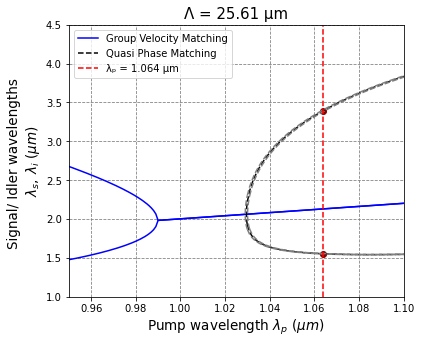

In [100]:
# Group Velocity Matching & Quasi Phase Matching
λp = 1.064; # μm
λs = 1.550;  
λi = λp * λs / (λs - λp)

xlims = [0.95, 1.1]
ylims = [1.0, 4.5]

fig, ax = plt.subplots(1,1,figsize = (6,5))

ax.plot(ngr_sols[:,0], ngr_sols[:,1], color = "blue", label = "Group Velocity Matching")
ax.plot(ngr_sols[:,0], ngr_sols[:,2], color = "blue")

ax.plot(qpm_sols_1[:,0], qpm_sols_1[:,1], linestyle = "dashed", color = "black", label = "Quasi Phase Matching")
ax.plot(qpm_sols_1[:,0], qpm_sols_1[:,2], linestyle = "dashed", color = "black")
ax.plot(qpm_sols_2[:,0], qpm_sols_2[:,1], linestyle = "dashed", color = "black")

ax.plot(qpm_sols_1_p[:,0], qpm_sols_1_p[:,1], linestyle = "dashed", color = "gray")
ax.plot(qpm_sols_1_p[:,0], qpm_sols_1_p[:,2], linestyle = "dashed", color = "gray")
ax.plot(qpm_sols_2_p[:,0], qpm_sols_2_p[:,1], linestyle = "dashed", color = "gray")

ax.plot(qpm_sols_1_m[:,0], qpm_sols_1_m[:,1], linestyle = "dashed", color = "gray")
ax.plot(qpm_sols_1_m[:,0], qpm_sols_1_m[:,2], linestyle = "dashed", color = "gray")
ax.plot(qpm_sols_2_m[:,0], qpm_sols_2_m[:,1], linestyle = "dashed", color = "gray")

# Show the pump wavelength
ax.axvline(λp, color = "red", linestyle = "dashed", label = "λₚ = 1.064 μm")
ax.scatter([λp, λp], [λs, λi], color = "darkred")

ax.grid(True, linestyle="dashed", color = "gray")

ax.set_xlabel("Pump wavelength $\lambda_{p}$ ($\mu m$)", fontsize = 13.5)
ax.set_ylabel("Signal/ Idler wavelengths \n$\lambda_{s},\,\lambda_{i}$ ($\mu m$)", fontsize = 13.5)

ax.set_title(f"Λ = {L_pole} μm", fontsize = 15)
ax.set_ylim(ylims[0],ylims[1])
ax.set_xlim(xlims[0],xlims[1])

ax.legend()

# plt.savefig(f"./Figures/qpm_match_L{L_pole}.png", bbox_inches="tight")

plt.show()

In [27]:
lbd_match = np.arange(0.5, 1.1 + 1e-4, 1e-3);
A_qpm = Avec_33; B_qpm = Bvec_33;
L_pole_tab = np.arange(17.5, 30.0, 2.5);
L_ppln = 25000;

qpm_tabs = [[],[]]

ngr_vec = match_ngr_full(lbd_match, A_qpm, B_qpm, f = 0.15)
for i, ll in enumerate(L_pole_tab):
    qpm_sols_1 = match_qpm_1(lbd_match, ll, A_qpm, B_qpm)
    qpm_tabs[0].append(qpm_sols_1)
    # qpm_tabs[1].append(qpm_sols_2)

<ipython-input-5-a7215ae36a71>:38: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(f_index_sq(λin, Avec, Bvec))


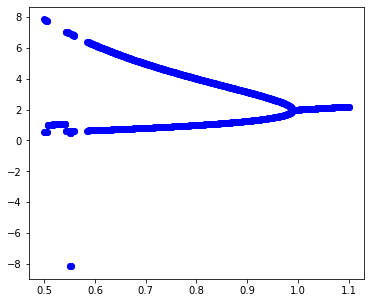

In [28]:
fig, ax = plt.subplots(1,1,figsize = (6,5))

ax.scatter(ngr_vec[:,0], ngr_vec[:,1], color = "blue", label = "Group Velocity Matching")
ax.scatter(ngr_vec[:,0], ngr_vec[:,2], color = "blue")

# ax.plot(qpm_tabs[0][:,0], qpm_tabs[0][:,1], linestyle = "dashed", color = "black", label = "Quasi Phase Matching")
# ax.plot(qpm_sols_1[:,0], qpm_sols_1[:,2], linestyle = "dashed", color = "black")
# ax.plot(qpm_sols_2[:,0], qpm_sols_2[:,1], linestyle = "dashed", color = "black")

*QPM with different pump wavelengths*

The poling period behaviour changes for shorter wavelength
- We see a peak QPM poling period. It seems there are two signal wavelengths which attain QPM condition simultaneously <br>
Q: Is it because they form the signal-idler pair? <br>
- The QPM requires a significantly shorter poling period

In [29]:
λ_pump_list = np.array([0.532, 0.808, 0.976, 1.030, 1.064]);
λ_signal_vec = np.arange(0.8, 1.7 + 1e-5, 1e-3);
d_pole_vec = np.array([2*np.pi/ qpm_dβ(np.inf, λp, λ_signal_vec, Avec_33, Bvec_33, sgn = 1) 
                       for λp in λ_pump_list]);

<ipython-input-18-da3c3695b932>:11: RuntimeWarning: divide by zero encountered in true_divide
  λ2 = λ0*λ1 / (λ1 - λ0);
<ipython-input-5-a7215ae36a71>:38: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(f_index_sq(λin, Avec, Bvec))


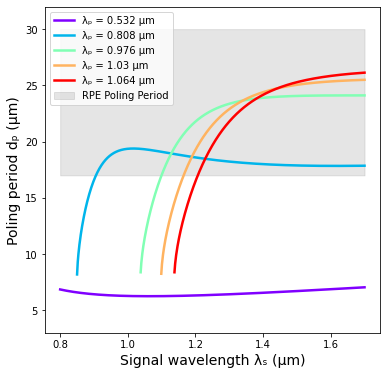

In [30]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
cmap = get_cmap('rainbow')
eta = 1
for i, λp in enumerate(λ_pump_list):
    ax.plot(λ_signal_vec, d_pole_vec[i], color = cmap((1-eta) + eta * i/(len(λ_pump_list)-1)), 
            label = f"λₚ = {λp} μm", linewidth = 2.5)
ax.fill_between(λ_signal_vec, 17, 30, color = "gray", alpha = 0.2, label = "RPE Poling Period")
ax.set_xlabel("Signal wavelength λₛ (μm)", fontsize = 14)
ax.set_ylabel("Poling period dₚ (μm)", fontsize = 14)
ax.set_ylim(3, 32)

plt.legend()
plt.savefig("./Figures/poling_period_vs_lambda.png")
plt.show()

# Calculating the relevant physical quantities

Units:
- Length: $\mu$m
- Time: fs
- Voltage: mV

In [31]:
A_qpm = Avec_33; B_qpm = Bvec_33;
pars_fit_33 = curve_fit(f_index_sq_33, lbd_data, nsq_data)[0]
Avec_33 = pars_fit_33[:3]; Bvec_33 = pars_fit_33[3:]

# Energy of the pump at 1 μm
c0 = 3 * 1e8; λp0 = 1;
epump = (1.054 * 1e-34) * (2*np.pi*c0)/(λp0 * 1e-6)

In [32]:
# Check what is the expected |c| for a square pulse
# |c| is in the fs^{-1/2} unit
np.array([np.sqrt(P/epump) for P in [0.1, 1, 10]]) / np.sqrt(1e15)

array([ 22.43515803,  70.94619905, 224.35158032])

In [33]:
def λ_idler(λp, λs):
    return λp*λs / (λs - λp);

In [34]:
# Dispersive coefficient
def β_coeff(λi, Avec, Bvec):
    dω = 1e-4; c0 =3e8;

    λ0, λp1, λm1 = λi / np.array([1, 1 + dω, 1 - dω])
    ω0, ωp1, ωm1 = (c0 * 1e6) / np.array([λ0, λp1, λm1])
    n0, np1, nm1 = np.array([f_index(λ, Avec, Bvec) for λ in [λ0, λp1, λm1]])
    
    β0 = (n0 / λ0) # /μm
    β1 = (np1 / λp1 - nm1 / λm1) / (ωp1 - ωm1) * 1e15 # fs/ μm
    β2 = (np1 / λp1 + nm1 / λm1 - 2 * n0 / λ0) / (ωp1 - ω0)**2 * (1e30) # fs^2/ μm
    return np.array([β0, β1, β2])

In [35]:
lbd, gg_data = pd.read_csv("./Data/gain_coefficient.csv").to_numpy().T

In [36]:
def gg_func(x, A0, A1, B, u):
    return A0 * (x**u) + A1 * x + B

ggpars, ggcov = curve_fit(gg_func, lbd, gg_data, p0=[1,1,0,1.5])
gg_func_fit = lambda λs: gg_func(λs, ggpars[0], ggpars[1], ggpars[2], ggpars[3])

# Coefficient κ
κ_coeff = lambda λs: gg_func_fit(λs) * np.sqrt(epump) * (1e-4) * np.sqrt(1e15)

In [37]:
ggpars

array([-6.47877963,  0.0511503 ,  0.36271593, -8.84618576])

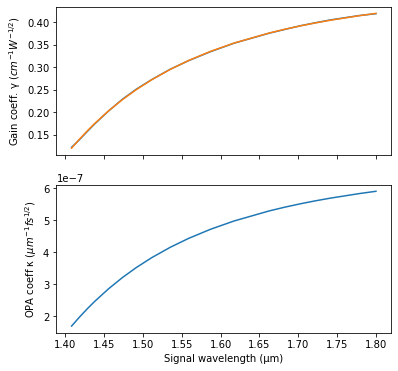

In [38]:
fig, ax = plt.subplots(2,1,figsize=(6,6),sharex=True)

ax[0].plot(lbd, gg_data)
ax[0].plot(lbd, gg_func_fit(lbd))
ax[1].plot(lbd, κ_coeff(lbd))

ax[1].set_xlabel("Signal wavelength (μm)")
ax[0].set_ylabel("Gain coeff. γ ($cm^{-1} W^{-1/2}$)")
ax[1].set_ylabel("OPA coeff κ ($μm^{-1} fs^{1/2}$)")

plt.show()

In [104]:
β_coeff(1.064, A_qpm, B_qpm)[1,0] - β_coeff(1.55, A_qpm, B_qpm)[1,0]

0.10603077092797886

In [105]:
β_coeff(3.393, A_qpm, B_qpm)[1,0] - β_coeff(1.55, A_qpm, B_qpm)[1,0]

0.06657899002081091

In [106]:
β_coeff(1.064, A_qpm, B_qpm)[2,0]

1.6273042030673994

In [107]:
β_coeff(1.55, A_qpm, B_qpm)[2,0]

0.7148689356515067

In [108]:
β_coeff(3.393, A_qpm, B_qpm)[2,0]

-3.8328450945622334

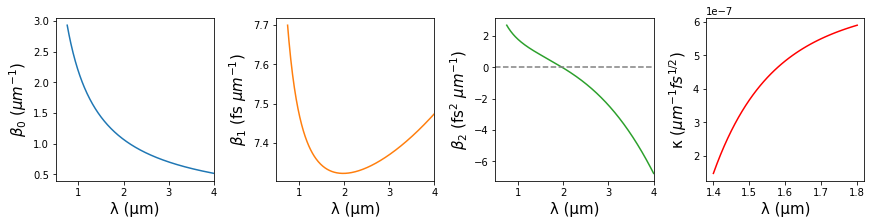

In [39]:
d33 = 19.5 # in pm/V
λtab = np.arange(0.75,4 + 5e-3,1e-2)
λtab2 = np.arange(1.4, 1.805, 1e-2)
βtab = np.array([β_coeff(ll, A_qpm, B_qpm) for ll in λtab])
κtab = np.array([κ_coeff(ll) for ll in λtab2])

fig, ax = plt.subplots(1,4,figsize = (12,3), constrained_layout=True)

ax[0].plot(λtab, βtab[:,0], color = "C0")
ax[1].plot(λtab, βtab[:,1], color = "C1")
ax[2].plot(λtab, βtab[:,2], color = "C2")
ax[2].axhline(0, color = "gray", linestyle = "dashed")

for j in range(len(ax)-1):
    ax[j].set_xlim(0.5, 4)

ax[3].plot(λtab2, κtab, color = "red")

for j in range(len(ax)):
    ax[j].set_xlabel("λ (μm)", fontsize = 15)

ax[0].set_ylabel(r"$\beta_{0}$ ($\mu m^{-1}$)", fontsize = 15)
ax[1].set_ylabel(r"$\beta_{1}$ (fs $\mu m^{-1}$)", fontsize = 15)
ax[2].set_ylabel(r"$\beta_{2}$ (fs$^2$ $\mu m^{-1}$)", fontsize = 15)
ax[3].set_ylabel("κ ($μm^{-1} fs^{1/2}$)", fontsize = 15)

plt.savefig("./Figures/ppln_pars.png")
plt.show()

### Checking mode dependence
If $\kappa$ is not sensitive to modal change, it should satisfy the following relation:

$\kappa ([n_p \lambda_p][n_s \lambda_s][n_i \lambda_i])^{1/2} = const$

In [40]:
# Trying to check how κ changes with λ
def nl_factor(λp, λs, Avec = Avec_33, Bvec = Bvec_33):
    λi = λp * λs / (λs-λp)
    nn_p = f_index(λp, Avec, Bvec).item()
    nn_s = f_index(λs, Avec, Bvec).item()
    nn_i = f_index(λi, Avec, Bvec).item()
    out = (np.sqrt(nn_p * λp) * np.sqrt(nn_s * λs) * np.sqrt(nn_i * λi))
    return out

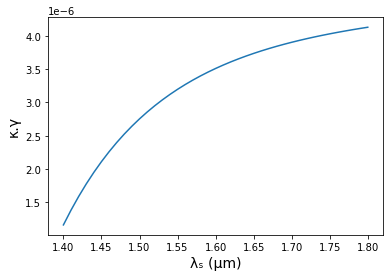

In [41]:
# This should be flat if κ is insensitive to mode profile
nl_fac_tab = np.array([nl_factor(1.064, λs) for λs in λtab2])
plt.plot(λtab2, κtab * nl_fac_tab)
plt.ylabel("κ.γ",  fontsize = 14)
plt.xlabel("λₛ (μm)", fontsize = 14)
plt.savefig("./Figures/nl_factor.png")
plt.show()

## Calculating walkoff distance, poling period

In [42]:
# Dispersion
beta0 = pd.DataFrame(np.array([λtab, βtab[:,0,0]]).T)
beta1 = pd.DataFrame(np.array([λtab, βtab[:,1,0]]).T)
beta2 = pd.DataFrame(np.array([λtab, βtab[:,2,0]]).T)

beta0.to_csv("./Data/rpe_beta0.csv")
beta1.to_csv("./Data/rpe_beta1.csv")
beta2.to_csv("./Data/rpe_beta2.csv")

In [43]:
# Dispersive properties for different pump
λp_tab = [0.808, 0.976, 1.03, 1.064]
λctrtab = np.array([1.32, 1.444, 1.55, 1.730])
signal_λ_tab = np.arange(1.3, 1.8 + 1e-5, 5e-3)
idler_λ_mat = np.array([λ_idler(λp, signal_λ_tab) for λp in λp_tab])

In [44]:
# QPM
Lqpm_mat = np.array([[np.round(2*np.pi/np.abs(qpm_dβ(np.inf, λp, λs, Avec_33, Bvec_33, sgn = 1))[0], 2) 
                      for λs in signal_λ_tab] for λp in λp_tab])

# Walkoff (ps/mm)
db1_ps_mat = np.array([[β_coeff(λp, Avec_33, Bvec_33)[1,0] - β_coeff(λs, Avec_33, Bvec_33)[1,0] 
                        for i, λs in enumerate(signal_λ_tab)] for λp in λp_tab])

db1_si_mat = np.array([[β_coeff(λs, Avec_33, Bvec_33)[1,0] - β_coeff(idler_λ_mat[p,i], Avec_33, Bvec_33)[1,0] 
                       for i, λs in enumerate(signal_λ_tab)] for p in range(len(λp_tab))])

# Second-order dispersion (ps^2/ mm)
b2_s_tab = np.array([β_coeff(λs, Avec_33, Bvec_33)[2,0] for λs in signal_λ_tab])
# b2_i_tab_1 = np.array([β_coeff(λi, Avec_33, Bvec_33)[2,0] for λi in idler_λ_tab_1])

In [66]:
1.55 * 1.064 / (1.55-1.064)

3.393415637860083

In [65]:
# Concrete number (ps/mm)
β_coeff(1.064, Avec_33, Bvec_33)[1,0] - β_coeff(1.55, Avec_33, Bvec_33)[1,0]

0.10603077092797886

In [69]:
# Concrete number (ps/mm)
β_coeff(3.393, Avec_33, Bvec_33)[1,0] - β_coeff(1.55, Avec_33, Bvec_33)[1,0]

0.06657899002081091

In [72]:
β_coeff(1.55, Avec_33, Bvec_33)[2,0]

0.7148689356515067

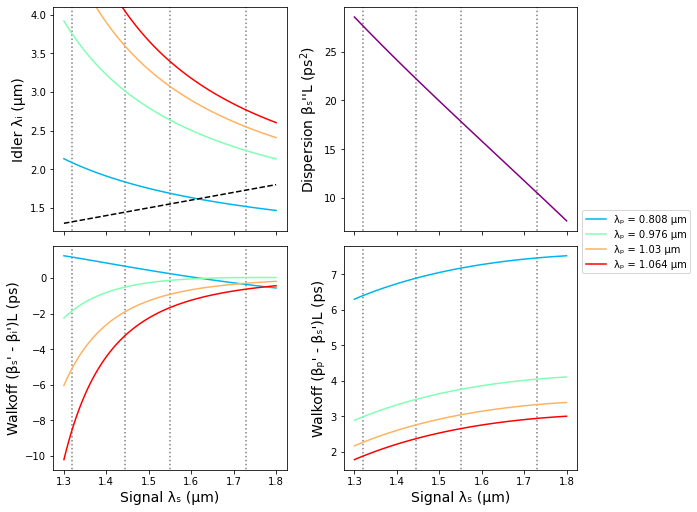

In [47]:
cmap = get_cmap('rainbow')
fig, ax = plt.subplots(2,2,figsize = (8,7), sharex=True, constrained_layout=True)

for i,j in product([0,1],[0,1]):
    for k, λc in enumerate(λctrtab):
        ax[i][j].axvline(λc, -50, 1e4, color = "gray", linestyle = "dotted")
    # ax[1].plot(λstab, dβ1tabs[i], color = f"C{i}", label = f"(λₚ, dₚ) = ({λpcut[i]}, {Lqpmcut[i]}) μm")

ax[0][0].set_ylabel("Idler λᵢ (μm)", fontsize = 14)
ax[0][0].set_ylim(1.2, 4.1)

ax[0][1].set_ylabel("Dispersion βₛ''L (ps$^{2}$)", fontsize = 14)

ax[1][0].set_ylabel("Walkoff (βₛ' - βᵢ')L (ps)", fontsize = 14)
ax[1][0].set_xlabel("Signal λₛ (μm)", fontsize = 14)

ax[1][1].set_ylabel("Walkoff (βₚ' - βₛ')L (ps)", fontsize = 14)
ax[1][1].set_xlabel("Signal λₛ (μm)", fontsize = 14)

ax[0][1].plot(signal_λ_tab, (L_ppln * 1e-3) * np.array([b2_s_tab]).T, color = "purple")

for j, λp in enumerate(λp_tab):
    col = cmap((j+1)/len(λp_tab))
    ax[0][0].plot(signal_λ_tab, idler_λ_mat[j], color = col, label = f"λₚ = {λp} μm")
    ax[1][0].plot(signal_λ_tab, (L_ppln * 1e-3) * db1_si_mat[j], color = col)
    ax[1][1].plot(signal_λ_tab, (L_ppln * 1e-3) * db1_ps_mat[j], color = col)
ax[0][0].plot(signal_λ_tab, signal_λ_tab, color = "black", linestyle = "dashed")

fig.legend(bbox_to_anchor = (1.2,0.6))
plt.savefig("./Figures/signal_idler_relation_2.png", bbox_inches = "tight")
plt.show()

# Calculation of the CW threshold

In [48]:
λp = 1.064 # μm
λs = 1.550 # μm
epump = (1.054 * 1e-34) * (2*np.pi*c0)/(λp * 1e-6)
L_pole = 25.61 # μm
L_wg = 25e3 # 2.5 cm
α_tot = 5e-1 # Total loss

In [49]:
# Phase-modulation strength
ϕm = 3.0
ρpm = jv(0, 3.0)
α_eff = 1 - (ρpm**2) * (1 - α_tot)

In [50]:
# Threshold pump, high-finesse (HF)
def pump_cth_hf(α, κ, L, dβ):
    """
    Calculating threshold amplitude (in fs^-0.5)
    """
    return np.sqrt(α)/(κ*L*np.abs(np.sinc(dβ*L/2)))

def pump_th_hf(α, κ, L, dβ):
    """
    Calculating threshold power (in W)
    """
    return np.square(np.abs(pump_cth_hf(α, κ, L, dβ))) * (epump * 1e15)

dβcw = lambda dp, λp, λs: qpm_dβ(dp, λp, λs, Avec = Avec_33, Bvec = Bvec_33, sgn = 1)

In [77]:
κ_coeff(1.55)

4.2058477668748665e-07

In [78]:
L_wg

25000.0

In [51]:
# Threshold amplitude
pump_cth_hf(0.5, κ_coeff(λs), L_wg, 0) * (1/np.sqrt(1e-3))

2126.627592288048

In [52]:
pump_th_hf(0.5, κ_coeff(λs), L_wg, 0)

0.844467606444461

## Illustrating the high-finesse solution
We mainly care about the phase-matched regime $\Delta\beta = 0$

In [53]:
# The signal wavelength under quasi phase-matching
λs_pm = match_qpm_1(λp, L_pole, Avec_33, Bvec_33)[1]

lbd_th = np.arange(1.4,1.8 + 1e-7,1e-4)
pump_cth = np.array([pump_cth_hf(α_tot, κ_coeff(λs), L_wg, dβcw(L_pole, λp, λs)) for λs in lbd_th])
pump_th = np.square(pump_cth) * (epump * 1e15)

pump_cth_pm = np.array([pump_cth_hf(α_tot, κ_coeff(λs), L_wg, 0) for λs in lbd_th])
pump_th_pm = np.square(pump_cth_pm) * (epump * 1e15)

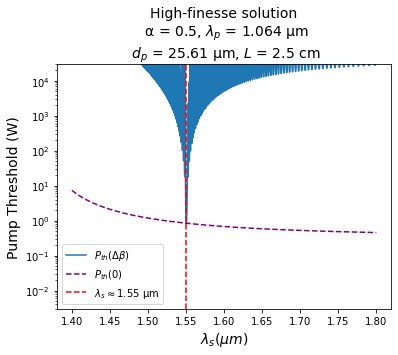

In [54]:
fig, ax = plt.subplots(1,1,figsize = (6,4.5))

ax.plot(lbd_th, pump_th, label = "$P_{th}(Δβ)$")
ax.plot(lbd_th, pump_th_pm, linestyle="dashed", color="purple", label = "$P_{th}(0)$")
ax.set_xlabel("$\lambda_{s} (\mu m)$", fontsize = 14)
ax.set_ylabel("Pump Threshold (W)", fontsize = 14)
ax.set_yscale("log")
ax.set_ylim(3e-3, 3e4)
ax.set_title(f"High-finesse solution\n α = {α_tot}, $\lambda_p$ = {λp} μm\n $d_p$ = {L_pole} μm, $L$ = {L_wg/1e4} cm", 
             fontsize = 14)
ax.axvline(λs_pm, color = "red", linestyle = "dashed", label = r"$λ_{s}\approx$" + f"{np.round(λs_pm,3)} μm")
ax.legend()
plt.savefig(f"./Figures/hf_sol_vs_lambda_dp{L_pole}.png", bbox_inches="tight")

plt.show()

## Pump threshold for different net loss

In [55]:
# Sanity check - solve the equation numerically
def eq_opa(z, y, κ, Δβ):
    a, b, c = y
    dydz = [κ*c*np.conj(b), -0.5*1j*Δβ * b + κ*np.conj(a)*c, 0.5*1j*Δβ * c - κ*a*b]
    return dydz

def net_gain(cc, Lz, λs, α, a0 = 1e-6, b0 = 0.0, Δβ = 0):
    κ = κ_coeff(λs) 
    yinit = np.complex128([a0, b0, cc[0]])
    sol = solve_ivp(eq_opa, [0,Lz], yinit, args = (κ,0), t_eval = np.array([0,Lz]))
    return np.square(np.abs(sol.y[0][-1]/sol.y[0][0])) - 1 - α/(1-α)

In [111]:
# Sample solution
ztab = np.linspace(0, 15000, 50)
yinit = np.array([1e-6+0*1j, 0 + 0*1j, 15+0*1j], dtype=np.complex128)
sol = solve_ivp(eq_opa, [0,15000], yinit, args=(κ_coeff(λs_pm), 0), t_eval=ztab)
L_wg = 15000

In [117]:
α_tab = np.logspace(-2, -0.01, 51);
cth0_tab = pump_cth_hf(α_tab, κ_coeff(λs_pm), L_wg, 0)

# The low-finesse limit
pth0_tab = pump_th_hf(α_tab, κ_coeff(λs_pm), L_wg, 0)

cth_tab = [];
xst = 10.0;
for α in α_tab:
    func = lambda c0: net_gain(c0, L_wg, λs_pm, α)
    xst = fsolve(func, xst)[0]
    cth_tab.append(xst)
cth_tab = np.array(cth_tab)
pth_tab = np.square(np.abs(cth_tab)) * (epump * 1e15)

In [58]:
# Split step data
# data_sp_step = pd.read_csv("./Data/opo_cw_threshold_ppln_s1.423.csv").to_numpy()

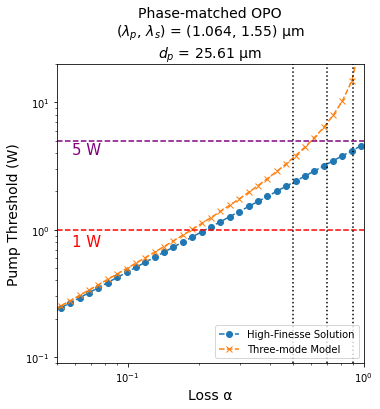

In [121]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5.5))
ax.plot(α_tab, pth0_tab, '--o', label = "High-Finesse Solution")
ax.plot(α_tab, pth_tab, '--x', label = "Three-mode Model")
# ax.plot(data_sp_step[:,0], data_sp_step[:,1], '--v', label = "Split-step")
ax.axhline(y=1, linestyle = "dashed", color = "red")
ax.axhline(y=5, linestyle = "dashed", color = "purple")
ax.axvline(x=0.5, linestyle = "dotted", color = "black")
ax.axvline(x=0.7, linestyle = "dotted", color = "black")
ax.axvline(x=0.9, linestyle = "dotted", color = "black")
ax.text(0.058, 0.74, "1 W", fontsize = 15, color = "red")
ax.text(0.058, 3.9, "5 W", fontsize = 15, color = "purple")
ax.set_xlabel("Loss α", fontsize = 14)
ax.set_ylabel("Pump Threshold (W)", fontsize = 14)
ax.set_xlim(0.05,1); ax.set_ylim(0.09, 20)
ax.set_xscale("log"); ax.set_yscale("log")
ax.legend(loc = "lower right")
ax.set_title("Phase-matched OPO\n" + 
             f"$(\lambda_p,\,\lambda_s)$ = ({λp}, {np.round(λs_pm, 3)}) μm\n$d_p$ = {L_pole} μm", 
             fontsize = 14)
plt.savefig(f"./Figures/opo_pth_vs_alpha_dp{L_pole}.png", bbox_inches="tight")
plt.show()

In [60]:
L_pole_tab = np.arange(20,30,0.02)
lbd_signal_tab = np.array([match_qpm_1(1.064, dp, Avec_33, Bvec_33)[1] for dp in L_pole_tab])

<ipython-input-5-a7215ae36a71>:38: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(f_index_sq(λin, Avec, Bvec))


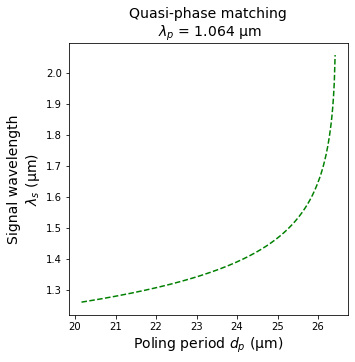

In [61]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(L_pole_tab, lbd_signal_tab, color = "green", linestyle = "dashed")
ax.set_xlabel("Poling period $d_p$ (μm)", fontsize = 14)
ax.set_ylabel("Signal wavelength\n$λ_s$ (μm)", fontsize = 14)
ax.set_title(f"Quasi-phase matching\n $\lambda_p$ = {λp} μm", fontsize = 14)
plt.savefig(f"./Figures/qpm_pump_{λp}.png", bbox_inches="tight")
plt.show()

In [62]:
# For all the posible signal wavelength
# αexp = 0.5;
αexp = np.round(α_eff, 3)
new_lbd =  lbd_signal_tab[lbd_signal_tab != np.array(None)]
new_L_pole = L_pole_tab[lbd_signal_tab != np.array(None)]
L_pole_min = np.round(np.min(new_L_pole),2)
L_pole_max = np.round(np.max(new_L_pole),2)

lbd_signal_tab_2 = np.linspace(1.4, np.max(new_lbd), 50)
cth0_tab_2_exp = pump_cth_hf(αexp, κ_coeff(lbd_signal_tab_2), L_wg, 0)
pth0_tab_2_exp = pump_th_hf(αexp, κ_coeff(lbd_signal_tab_2), L_wg, 0)

cth_tab_2_exp = [];
xst = 10.0;
for λs in lbd_signal_tab_2:
    func = lambda c0: net_gain(c0, L_wg, λs, αexp)
    xst = fsolve(func, xst)[0]
    cth_tab_2_exp.append(xst)
    
cth_tab_2_exp = np.array(cth_tab_2_exp)
pth_tab_2_exp = np.square(np.abs(cth_tab_2_exp)) * (epump * 1e15)

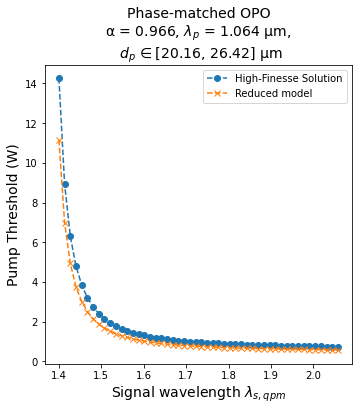

In [1333]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5.5))
ax.plot(lbd_signal_tab_2, pth0_tab_2_exp, '--o', label = "High-Finesse Solution")
ax.plot(lbd_signal_tab_2, pth_tab_2_exp, '--x', label = "Reduced model")
ax.set_xlabel("Signal wavelength $λ_{s,qpm}$", fontsize = 14)
ax.set_ylabel("Pump Threshold (W)", fontsize = 14)
ax.legend(loc = "upper right")
ax.set_title("Phase-matched OPO\n" + 
             f"α = {αexp}, $\lambda_p$ = {λp} μm,\n $d_p\,\in$[{L_pole_min}, {L_pole_max}] μm", 
             fontsize = 14)
plt.savefig(f"./Figures/opo_pth_vs_ls_alpha{αexp}.png", bbox_inches="tight")
plt.show()

# Determining bandwidth

In [1697]:
# Change in β under QPM
def δβ_qpm(λp, λs, λsctr, L = 1.0, Avec = Avec_33, Bvec = Bvec_33):
    λi = λp * λs / (λs - λp)  # μm
    βs = β_coeff(λs, Avec, Bvec)[0,0]
    βi = β_coeff(λi, Avec, Bvec)[0,0]
    
    # Saddle point
    λictr = λp * λsctr / (λsctr - λp)
    βsctr = β_coeff(λsctr, Avec, Bvec)[0,0]
    βictr = β_coeff(λictr, Avec, Bvec)[0,0]
    
    δβ = (βs + βi) - (βsctr + βictr)
    return δβ * L

# Undepleted limit
def gain_udl(λp, λs, λsctr, L, cin, 
             αc = 0, ain = 0, Avec = Avec_33, Bvec = Bvec_33, ndigit = 10):
    """
    Calculating single-pass gain for a single pass
    """
    δβ = δβ_qpm(λp, λs, λsctr, L = 1.0, Avec = Avec, Bvec = Bvec)
    κs = κ_coeff(λs)
    γ = np.sqrt((δβ/2)**2 + (κs*ain)**2)
    out = κs * np.abs(cin) * L * np.sinc(γ * L)
    out = np.square(out)
    return np.round(out, ndigit) - αc

def sine_pm(τ, φa, Ω = 2*np.pi):
    return φa * (np.sin(Ω*τ/2) ** 2)

def net_loss(τ, αc, φa, f = sine_pm):
    out = αc
    out -= 2* np.log(np.cos(sine_pm(τ, φa)))
    return out

In [2161]:
# Important function: constant phase line
def F(τ,λ,δ2s,φp,ωctr):
    out = δ2s/2* ((2*np.pi*c0 * 1e-6) / λgrid2 - ωctr)**2
    out = out - φp * np.square(np.sin(np.pi * τ))
    return out

## Phase mismatch vs GVM condition

In [2404]:
lbd_pump = np.arange(0.8, 1.1, 1e-3);
ngr_sols = match_ngr_full(lbd_pump, Avec_33, Bvec_33, f = 0.15)

In [2415]:
λctr = 1.55
λstab = np.arange(1.3,2.0, 0.01)

λpcut = [0.808, 0.976, 1.03, 1.064]
dβ1tabs = np.array([[δβ_qpm(λp, λs, λctr, L = L_wg, Avec = Avec_33, Bvec = Bvec_33) 
                     for λs in λstab] for λp in λpcut])
Lqpmcut = np.array([np.round(2*np.pi/np.abs(qpm_dβ(np.inf, λp, λctr, Avec_33, Bvec_33, sgn = 1))[0], 2) 
                    for λp in λpcut])

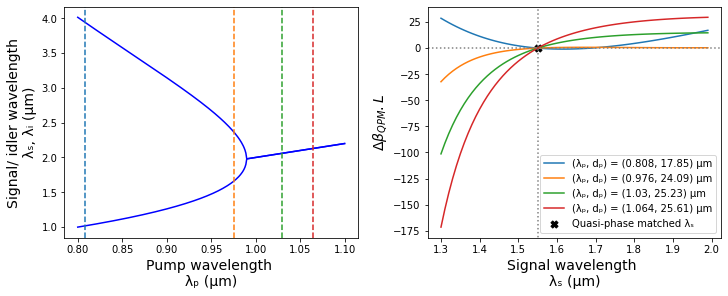

In [2407]:
fig, ax = plt.subplots(1,2,figsize = (10,4), constrained_layout=True)

ax[0].plot(lbd_pump, ngr_sols[:,1], color = "blue")
ax[0].plot(lbd_pump, ngr_sols[:,2], color = "blue")
for i in range(len(dβ1tabs)):
    ax[0].axvline(λpcut[i], ymin = 0, ymax = 4, color = f"C{i}", linestyle = "dashed")
    ax[1].plot(λstab, dβ1tabs[i], color = f"C{i}", label = f"(λₚ, dₚ) = ({λpcut[i]}, {Lqpmcut[i]}) μm")

ax[0].set_xlabel("Pump wavelength \nλₚ (μm)", fontsize = 14)
ax[0].set_ylabel("Signal/ idler wavelength\nλₛ, λᵢ (μm)", fontsize = 14)
ax[1].axhline(0,0,5, color="gray", linestyle="dotted")
ax[1].axvline(λsctr,-200,200, color="gray", linestyle="dotted")
ax[1].scatter([λsctr], [0], marker = "X", s = 50, color="black", label = "Quasi-phase matched λₛ")
ax[1].set_xlabel("Signal wavelength \nλₛ (μm)", fontsize = 14)
ax[1].set_ylabel(r"$\Delta\beta_{QPM}.L$", fontsize = 14)

plt.legend()
plt.savefig("./Figures/qpm_plot_2.png", bbox_inches = "tight")
plt.show()

In [2425]:
# Trying to compare the resulting phase mismatch
λstab = np.arange(1.3,2.0, 0.01)
λctrtab = np.array([1.32, 1.444, 1.55, 1.730, 1.870])
λpcut = np.array([0.808, 0.976, 1.03, 1.064])

dβ1tabs_var = np.array([[[δβ_qpm(λp, λs, λctr, L = L_wg, Avec = Avec_33, Bvec = Bvec_33) 
                      for λs in λstab] for λp in λpcut] for λctr in λctrtab])
Lqpmcut_var = np.array([[np.round(2*np.pi/np.abs(qpm_dβ(np.inf, λp, λctr, Avec_33, Bvec_33, sgn = 1))[0], 2) 
                    for λp in λpcut] for λctr in λctrtab])

In [2419]:
Lqpmcut_var

array([[18.17, 23.52, 23.3 , 22.42],
       [17.93, 23.99, 24.75, 24.76],
       [17.85, 24.09, 25.23, 25.61],
       [17.87, 24.11, 25.52, 26.19],
       [17.96, 24.1 , 25.59, 26.35]])

In [2424]:
δβ_qpm(0.808, 1.55, 1.55)

0.0

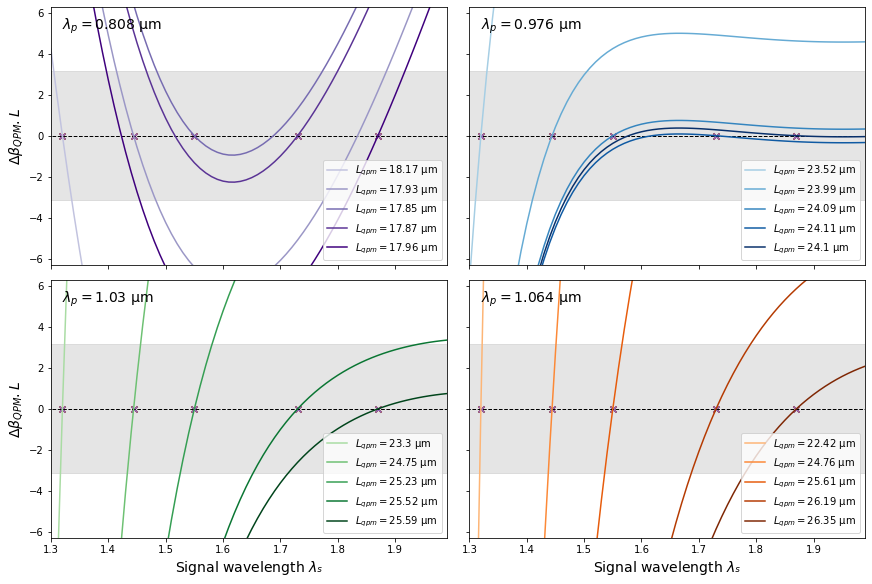

In [2486]:
fig, ax = plt.subplots(2,2,figsize = (12,8), sharex=True, sharey=True, constrained_layout = True)
cmap_tabs = ["Purples", "Blues", "Greens", "Oranges", "Reds"]
eta = 0.65; fz_label = 14;

for n, lp in enumerate(λpcut):
    rr = int(n/2); cc = int(np.mod(n,2));
    cmap = get_cmap(cmap_tabs[n])
    ax[rr][cc].plot([1.0, 3.0], np.zeros(2), color = "black", linestyle = "--", linewidth = 1)
    ax[rr][cc].fill_between([1.0, 3.0], -np.pi, np.pi, color = "gray", alpha=0.2)
    ax[rr][cc].set_xlim(np.min(λstab), np.max(λstab))
    ax[rr][cc].set_ylim(-2 * np.pi, 2 * np.pi)
    ax[rr][cc].text(1.32, 5.2, r"$\lambda_{p} = $" + f"{lp} μm", fontsize = 14)
    for i, lctr in enumerate(λctrtab):
        ax[rr][cc].plot(λstab, dβ1tabs_var[i][n], color = cmap((1-eta) + eta * i/(len(λ_pump_list)-1)),
                       label = r"$L_{qpm} = $" + f"{Lqpmcut_var[i][n]} μm")
        ax[rr][cc].scatter(λctrtab, np.zeros(len(λctrtab)), marker = "x")
    
    ax[rr][cc].legend(loc = "lower right")

ax[0][0].set_ylabel(r"$\Delta\beta_{QPM}.L$", fontsize = fz_label)
ax[1][0].set_ylabel(r"$\Delta\beta_{QPM}.L$", fontsize = fz_label)
ax[1][0].set_xlabel("Signal wavelength $λₛ$", fontsize = fz_label)
ax[1][1].set_xlabel("Signal wavelength $λₛ$", fontsize = fz_label)

plt.savefig("./Figures/qpm_plot_var.png", bbox_inches = "tight")
plt.show()

## Phase space dynamics

In [2647]:
λp = λpcut[3];  
λsctr = λctrtab[2];
λictr = λp * λs / (λs - λp)
ωsctr = 3e14 * (2 * np.pi/ λsctr) * 1e-12 # THz;
Lqpm = np.round(2*np.pi/np.abs(qpm_dβ(np.inf, λp, λsctr, Avec_33, Bvec_33, sgn = 1))[0], 2)

β1s = β_coeff(λsctr, Avec_33, Bvec_33)[1,0] * 1e-3      # ps / μm
β2s = β_coeff(λsctr, Avec_33, Bvec_33)[2,0] * (1e-3)**2 # ps^2 / μm
δ1s = β1s * L_ppln # ps
δ2s = β2s * L_ppln # ps^2
# δ2s = 2e-3 # ps^2

# Phase & Intensity modulation
φp = 3.2; φa = 1.0;

# Loss
α_tot = 0.5

# Threshold amplitude
cth = np.sqrt(α_tot)/(κ_coeff(λsctr) * L_wg) # fs^{-1/2}

In [2648]:
# 0. Calculating the phase space diagram
# Normalizing time to T
λvec2 = np.linspace(1.25, 1.85, 26) # Signal wavelength, μm
τvec2 = np.linspace(-0.5, 0.5, 26) # In ps
λgrid2, τgrid2 = np.meshgrid(λvec2, τvec2)

# Vector plots: dτ/dt, dλ/dt
dτvec = δ2s * ((2*np.pi*c0 * 1e-6) / λgrid2 - ωsctr)
dλvec = -(λgrid2**2/ (2* c0 * 1e-6)) * φp * np.sin(2*np.pi * τgrid2)

# Constant phase lines
# The vectors should be parallel to these lines
funcF = F(τgrid2, λgrid2, δ2s, φp, ωsctr)

In [2649]:
# 1. Calculating the separatrix: δ(ω) + ϕ(τ) = C
τlist = np.linspace(-0.5, 0.5, 101)
ωlist = np.sqrt(2 * φp / δ2s) * np.sin(2*np.pi *τlist/2) # THz
λplist = (c0 * 1e-6) * (2*np.pi/ (ωsctr + ωlist)) # μm
λmlist = (c0 * 1e-6) * (2*np.pi/ (ωsctr - ωlist)) # μm

In [2650]:
# 2. Calculating gain - loss profile
λvec = np.arange(1.25, 1.85 + 1e-5, 0.005) # Signal
τvec = np.linspace(-0.5, 0.5, 51)

λgrid, τgrid = np.meshgrid(λvec, τvec)
ggrid = np.zeros_like(λgrid)
Pratio = 3.1;
pump_in = cth * np.sqrt(Pratio);

for i, j in product(range(len(τvec)), range(len(λvec))):
    ggrid[i,j] = gain_udl(λp, λvec[j], λsctr, L_wg, pump_in) - net_loss(τvec[i], α_tot, φa)

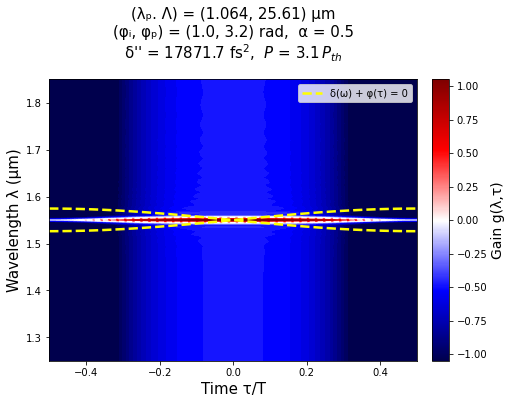

In [2651]:
# DYNAMICAL PHASE SPACE PLOT
fig, ax = plt.subplots(1,1, figsize = (7,5.5), constrained_layout=True)
ax.plot(τlist, λplist, color = "yellow", linestyle = "dashed", linewidth = 2.5, label = "δ(ω) + φ(τ) = 0")
ax.plot(τlist, λmlist, color = "yellow", linestyle = "dashed", linewidth = 2.5)
ax.contour(τgrid, λgrid, ggrid, levels = [0.0], colors = "white", linestyles = "dashed")

vm = np.min([np.abs(np.min(ggrid)), np.abs(np.max(ggrid))])
ctr_level = np.linspace(-vm, vm, 51)
ctr_level[0] = np.min(ggrid)
ctr_level[-1] = np.max(ggrid)
ctr_plt = ax.contourf(τgrid, λgrid, ggrid, levels = ctr_level, vmin = -vm, vmax = vm, cmap = "seismic")
# ax.quiver(τgrid2, λgrid2, dτvec, dλvec, color="white", linewidths = 4, angles='xy', scale_units='xy', scale=5.0)
cbar = fig.colorbar(
    ScalarMappable(norm=ctr_plt.norm, cmap=ctr_plt.cmap),
)

cbar.set_label("Gain g(λ,τ)", fontsize = 14)

ax.set_title(f"(λₚ. Λ) = ({λp}, {Lqpm}) μm\n(φᵢ, φₚ) = {φa, φp} rad,  α = {α_tot}" + 
             f"\nδ'' = {np.round(δ2s * 1e6, 1)} fs$^2$,  " + f"$P$ = {Pratio}" + r"$\,P_{th}$", fontsize = 15,
             y = 1.05)

ax.set_xlabel("Time τ/T", fontsize = 15)
ax.set_ylabel("Wavelength λ (μm)", fontsize = 15)

plt.legend()
plt.savefig(f"./Figures/bandwidth_lp{λp}_im{φa}_pm{φp}_d2s{np.round(δ2s * 1e6,1)}_Pr{Pratio}.png", bbox_inches = "tight")
plt.show()

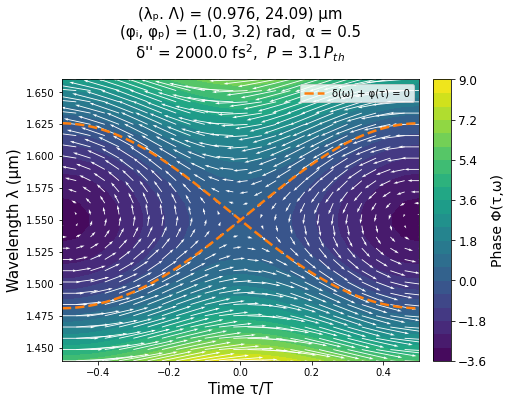

In [2281]:
# CONSTANT PHASE PLOT
fig, ax = plt.subplots(figsize = (7,5.5), constrained_layout=True)
fC_ctr = ax.contourf(τgrid2, λgrid2, funcF, levels = 20)
ax.plot(τlist, λplist, color = "C1", linestyle = "dashed", label = "δ(ω) + φ(τ) = 0", linewidth = 2.5)
ax.plot(τlist, λmlist, color = "C1", linestyle = "dashed", linewidth = 2.5)
ax.quiver(τgrid2, λgrid2, dτvec, dλvec, color="white", linewidths = 4, angles='xy', scale_units='xy', scale=1.5)

ax.set_title(f"(λₚ. Λ) = ({λp}, {Lqpm}) μm\n(φᵢ, φₚ) = {φa, φp} rad,  α = {α_tot}" + 
             f"\nδ'' = {np.round(δ2s * 1e6, 1)} fs$^2$,  " + f"$P$ = {Pratio}" + r"$\,P_{th}$", fontsize = 15,
             y = 1.05)

ax.set_xlabel("Time τ/T", fontsize = 15)
ax.set_ylabel("Wavelength λ (μm)", fontsize = 15)

cbar = fig.colorbar(fC_ctr)
cbar.set_label("Phase Φ(τ,ω)", fontsize = 14)
cbar.ax.tick_params(labelsize = 12)

plt.legend()
plt.savefig(f"./Figures/cphase_lp{λp}_im{φa}_pm{φp}_d2s{np.round(δ2s * 1e6,1)}.png", bbox_inches = "tight")
plt.show()

### Calculating the bandwidth

In [1266]:
ϕpvec = np.arange(1,50.5,1)
Dωmax =  2 * np.sqrt(2 * ϕpvec / np.abs(δ2s)) # fs

In [1268]:
δ2s

-3487.6505659522945

<bound method Axes.set_xlabel of <AxesSubplot:>>

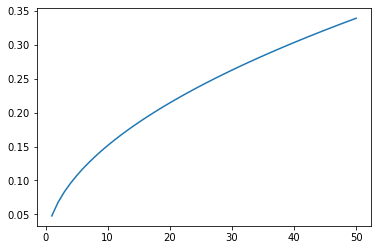

In [1269]:
fig, ax = plt.subplots(1,1)
ax.plot(ϕpvec, Dωmax)
ax.set_xlabel